In [1]:
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import librosa
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from models.conv_vae import ConvVAE, vae_loss
from readers.coughvid_reader import CoughVID_NormalAnomaly, CoughVID_Dataset
from readers.featurizer import Wave2Mel
from tools.utils import load_ckpt
from readers.collate_fn import collate_fn
from readers.audio import AudioSegment
from readers.featurizer import Wave2Mel, get_wav_label
w2m = Wave2Mel(sr=16000)

In [14]:
from models.conv_vae import ConvVAE, vae_loss

# 测试集读取和测试

In [2]:
healthy_p_list, healthy_label_list, unhealthy_p_list, unhealthy_label_list = CoughVID_NormalAnomaly()
print(len(healthy_p_list), len(unhealthy_p_list))
print(len(healthy_label_list), len(unhealthy_label_list))
# 训练集取健康样本的13000个，剩下503个和非健康样本的503个一起组成验证集，测试集就是验证集。
trlen = 13200
valen = len(healthy_p_list) - trlen
print("train len valid len", trlen, valen)
trp, trl, vap, val = healthy_p_list[:trlen], healthy_label_list[:trlen], healthy_p_list[trlen:], healthy_label_list[trlen:]
vap.extend(unhealthy_p_list[:valen])
val.extend(unhealthy_label_list[:valen])
# print(len(trp), len(trl))
print(len(vap), len(val))

13709 4227
13709 4227
train len valid len 13200 509
1018 1018


In [3]:
tic = time.time()
valid_dataset = CoughVID_Dataset(path_list=vap, label_list=val)
toc = time.time()
print("Test Dataset Creat Completely, cost time:", toc-tic)

Loading:   0%|                                                                                | 0/1018 [00:00<?, ?it/s]C:\Program Files (zk)\PythonFiles\AClassification\SoundDL-CoughVID\readers\audio.py:120: UserWarning: PySoundFile failed. Trying audioread instead.
  samples, sample_rate = librosa.load(file)  # , dtype='float32')
C:\Users\zhaoke\miniconda3\envs\torch-0\lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Loading:   0%|                                                                        | 1/1018 [00:00<16:49,  1.01it/s]C:\Program Files (zk)\PythonFiles\AClassification\SoundDL-CoughVID\readers\audio.py:120: UserWarning: PySoundFile failed. Trying audioread instead.
  samples, sample_rate = librosa.load(file)  # , dtype='float32')
C:\Users\zhaoke\miniconda3\envs\torch-0\lib\sit

Test Dataset Creat Completely, cost time: 70.34470891952515


In [4]:
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
configs = {
    "run_save_dir": "./runs/tdnn_coughvid/",
    "model":{
        "num_class": 3,
        "input_length": 94,
        "wav_length": 48000,
        "input_dim": 512,
        "n_mels": 128,
        },
    "fit":{
        "batch_size": 64,
        "epochs" : 23,
        "start_scheduler_epoch": 6
        },
}
resume_path = "202404271202_tdnn_focalloss"
load_epoch = 22

device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
num_epoch = configs["fit"]["epochs"]
model = ConvVAE(shape=(1, configs["model"]["input_length"], configs["model"]["n_mels"]), flat=True).to(device)
resume_path = f"./runs/tdnn_coughvid/{resume_path}/model_epoch_{load_epoch}"
state_dict = torch.load(os.path.join(resume_path, f'model_{load_epoch}.pth'))
model.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:
show_path = random.choice(vap)
print(show_path)

F:/DATAS/COUGHVID-public_dataset_v3/coughvid_20211012/fa641666-b850-48eb-85be-989e3c466ddb.webm


In [85]:
import IPython.display as ipd
ipd.Audio(show_path)

C:\Users\zhaoke\AppData\Local\Temp\ipykernel_1388\3506015856.py:1: UserWarning: PySoundFile failed. Trying audioread instead.
  s, r = librosa.load(show_path)


shape of x_wav torch.Size([1, 48000])
shape of x_mel torch.Size([1, 1, 94, 128])


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 128])

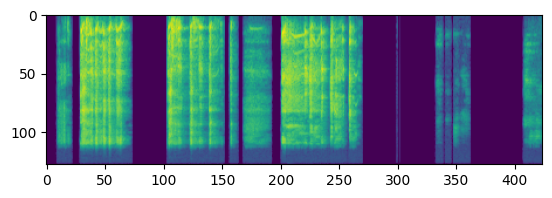

In [10]:
s, r = librosa.load(show_path)
plt.figure(2)
x_mel = w2m(torch.from_numpy(s))
plt.imshow(x_mel)
x_wav = torch.from_numpy(get_wav_label(show_path)).to(torch.float32).unsqueeze(0)
# print("shape of x_wav", x_wav.shape)
x_mel = w2m(x_wav).transpose(1, 2).unsqueeze(1).to(device)
print("shape of x_wav", x_wav.shape)
print("shape of x_mel", x_mel.shape)
# y_label = torch.tensor(y_label, device=device)
x_recon, _, _, _ = model(x=x_mel)

plt.figure(3)
x_recon = x_recon.squeeze().transpose(0,1).detach().cpu().numpy()
plt.imshow(x_mel.squeeze().transpose(0,1).detach().cpu().numpy())
plt.xticks([])
plt.yticks([])

plt.figure(4)
plt.imshow(x_recon)
plt.xticks([])
plt.yticks([])

# plt.show()

In [29]:
k=4
show_paths = random.choices(vap, k=k)
plt.figure(1)
x_idx = 0
x_input, x_labels = [], []
for item in show_paths:
    x_wav, y_label = torch.from_numpy(get_wav_label(vap[x_idx])).to(torch.float32), val[x_idx]
    # print("shape of x_wav", x_wav.shape)
    x_mel = w2m(x_wav).transpose(0, 1).unsqueeze(0).to(device)
    y_label = torch.tensor(y_label, device=device)
    print("shape of x_mel", x_mel.shape)
    x_input.append(x_mel)
    x_labels.append(y_label)
x_mel = torch.stack(x_input, dim=0)
y_labels = torch.stack(x_labels, dim=0)
print("shape of x_mel", x_mel.shape)
print("shape of x_mel", y_labels.shape)

shape of x_mel torch.Size([1, 94, 128])
shape of x_mel torch.Size([1, 94, 128])
shape of x_mel torch.Size([1, 94, 128])
shape of x_mel torch.Size([1, 94, 128])
shape of x_mel torch.Size([4, 1, 94, 128])
shape of x_mel torch.Size([4])


<Figure size 640x480 with 0 Axes>

./runs/tdnn_coughvid/202404271202_tdnn_focalloss/model_epoch_22epoch{load_epoch}_recon.png


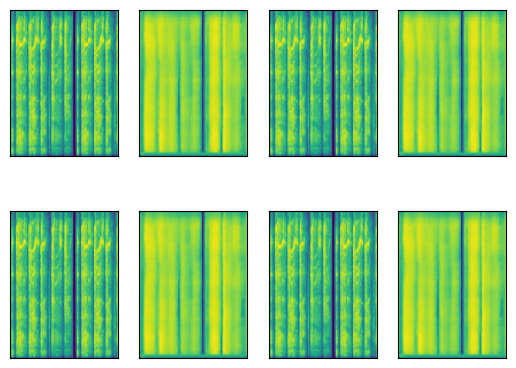

In [33]:
x_recons, _, _, _ = model(x=x_mel)
for x_idx in range(len(x_recons)):
    plt.subplot(2, k, 2*x_idx+1)
    plt.imshow(x_mel[x_idx, :,:,:].squeeze().transpose(0,1).detach().cpu().numpy())
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(2, k, 2*x_idx+2)
    x_recon = x_recons[x_idx,:,:,:].squeeze().transpose(0,1).detach().cpu().numpy()
    plt.imshow(x_recon)
    plt.xticks([])
    plt.yticks([])
print(resume_path+"epoch{load_epoch}_recon.png")
plt.savefig(f"{resume_path}/epoch{load_epoch}_recon.png", format="png", dpi=300)
plt.show()

In [15]:
model.eval()
tsne_input = []
loss_list = []
labels = []
# for x_idx, (x_wav, y_label, _) in enumerate(tqdm(test_loader, desc="Validate")):
for x_idx in tqdm(range(len(vap)), desc="Testing"):
    x_wav, y_label = torch.from_numpy(get_wav_label(vap[x_idx])).to(torch.float32).unsqueeze(0), val[x_idx]
    # print("shape of x_wav", x_wav.shape)
    x_mel = w2m(x_wav).transpose(1, 2).unsqueeze(1).to(device)
    y_label = torch.tensor(y_label, device=device)
    # print("shape of x_mel", x_mel.shape)
    # break
    recon_mel, z, mean_latent, logvar_latent = model(x=x_mel)
    # recon_loss = self.recon_loss(recon_spec, x_mel)
    pred_loss = vae_loss(x_mel, recon_mel, mean_latent, logvar_latent)
    
    # if x_idx == 0:
    tsne_input.append(z)
    labels.append(y_label)
    # else:
    #     tsne_input = torch.concat((tsne_input, z), dim=0)
    #     labels = torch.concat((labels, y_label), dim=0)
    loss_list.append(pred_loss.item())
    # if x_idx * configs["fit"]["batch_size"] > 800:
    #     break

Testing: 100%|█████████████████████████████████████████████████████████████████████| 1018/1018 [01:24<00:00, 12.09it/s]


In [16]:
print("tsne_input shape:", len(tsne_input))
print("loss_list shape:", len(loss_list))
print("lables shape:", len(labels))
# loss_list
# if epoch > 3:
#     self.plot_reduction(resume_path="", load_epoch=epoch, reducers=["heatmap"])
# heatmap_input = heatmap_input.detach().cpu().numpy()
# labels = labels.detach().cpu().numpy()
# calc_accuracy(pred_matrix=heatmap_input, label_vec=labels,
#               save_path=run_save_dir + f"/accuracy_epoch_{epoch_id}.txt")
# plot_heatmap(pred_matrix=heatmap_input, label_vec=labels,
#              ticks=["healthy", "symptomatic", "COVID-19"],
#              save_path=run_save_dir + f"/heatmap_epoch_{epoch_id}.png")

tsne_input shape: 1018
loss_list shape: 1018
lables shape: 1018


In [17]:
tsne_matrix = torch.concat(tsne_input, dim=0)
print(tsne_matrix.shape)
tsne_matrix = tsne_matrix.detach().cpu().numpy()
tsne_matrix

torch.Size([1018, 128])


array([[-0.1370977 , -0.7209723 , -1.6098111 , ...,  0.0969893 ,
        -0.9438467 ,  0.15255986],
       [-0.31705812,  0.44825464, -0.9284084 , ...,  0.5518278 ,
        -0.04645177,  0.62081736],
       [-0.24976738,  1.5939335 ,  0.5665238 , ...,  0.7736881 ,
        -0.8703268 , -0.20358285],
       ...,
       [-0.77099735, -0.31716466, -0.04621741, ...,  0.14225881,
        -0.00740942,  0.5175209 ],
       [ 0.20776874, -0.7211326 , -0.45991412, ...,  0.5377326 ,
        -0.02359815, -0.11624493],
       [ 0.4532686 , -1.0134264 , -0.6947971 , ..., -0.11778801,
        -0.23356353, -0.5622024 ]], dtype=float32)

In [18]:
loss_list

[300.16961669921875,
 153.3475799560547,
 207.38807678222656,
 321.25518798828125,
 314.1907043457031,
 186.96070861816406,
 243.5087127685547,
 139.67091369628906,
 191.3949737548828,
 106.72848510742188,
 190.87110900878906,
 279.1758728027344,
 231.02076721191406,
 257.26654052734375,
 170.4564208984375,
 179.5405731201172,
 167.63436889648438,
 167.7209930419922,
 364.38067626953125,
 226.11102294921875,
 171.46389770507812,
 143.44424438476562,
 257.17694091796875,
 391.31689453125,
 230.74415588378906,
 193.14370727539062,
 158.22425842285156,
 190.20021057128906,
 479.8726806640625,
 229.360107421875,
 609.1951904296875,
 182.34381103515625,
 149.84396362304688,
 184.7122802734375,
 174.66758728027344,
 206.4984130859375,
 328.4771728515625,
 319.6744079589844,
 193.84722900390625,
 280.90972900390625,
 215.2174835205078,
 240.8876190185547,
 274.04925537109375,
 379.4544372558594,
 264.42840576171875,
 364.05078125,
 508.2357482910156,
 100.1654281616211,
 76.447021484375,
 216

In [19]:
labels_list = torch.stack(labels, dim=0)
print(labels_list.shape)
labels_list = labels_list.detach().cpu().numpy()
labels_list

torch.Size([1018])


array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [20]:
labels_list

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

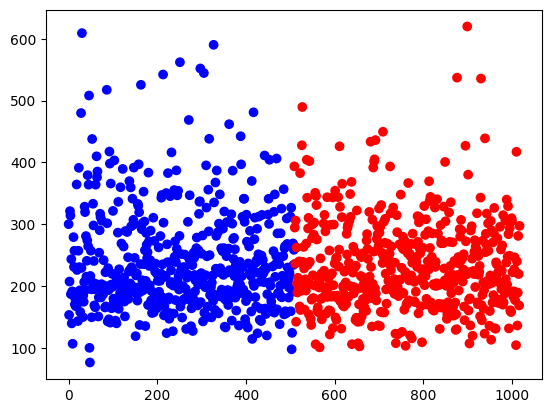

In [21]:
import matplotlib.pyplot as plt
cl = {0:"blue", 1:"red"}
plt.figure(0)
plt.scatter(range(len(loss_list)), loss_list, c=[cl[v] for v in labels_list])
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1006 samples in 0.001s...
[t-SNE] Computed neighbors for 1006 samples in 0.160s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1006
[t-SNE] Computed conditional probabilities for sample 1006 / 1006
[t-SNE] Mean sigma: 3.863256
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.315674
[t-SNE] KL divergence after 300 iterations: 1.063154


C:\Program Files (zk)\PythonFiles\AClassification\SoundDL-CoughVID\tools\plotter.py:52: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  sns.scatterplot(


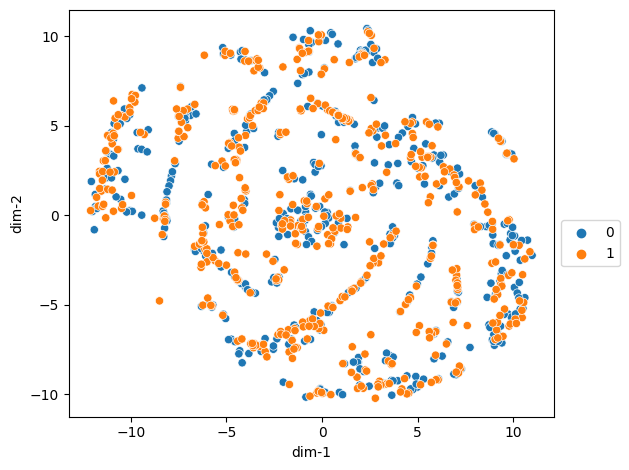

In [56]:
from tools.plotter import plot_tSNE
plot_tSNE(embd=tsne_matrix, names=labels_list, save_path="./runs/tdnn_coughvid/202404261420_tdnn_focalloss/epoch22_tsne.png")